In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
pd.set_option("precision", 20)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2
from pool_state import v3Pool
import psycopg2
from swap_utils import *
from swap import swap
from sim import sim
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime
import json


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div align="center">
    
# Institutional Tooling V0 Demo

</div>


    


### 1. Historical Liquidity Distribution / Market Depth
* Useful when investors want to manually investigate liquidity distribution in history
* Current implementation: 
    - Input: as_of (can be intra-block)
    - Output: liquidity at each tick
* Quick iteration:
    - Input: time_range, frequency
    - Output: dataframe of liquidity distribution at each point in time + gif displaying liquidity dynamics

Initializing liquidity
CPU times: user 23.6 s, sys: 11 s, total: 34.6 s
Wall time: 53.4 s


Text(0.5, 1.0, 'Liquidity Distribution as of block number 14814941.0')

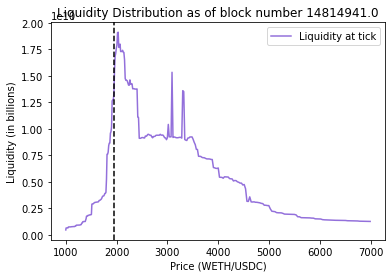

In [34]:
%%time
########### INPUT BLOCK ###############

pool_add              = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
block_number          = 14814941
transaction_index     = 0
display_price_lower   = 1000
display_price_upper   = 7000

#######################################

as_of = block_number + transaction_index / 1e4
pool = v3Pool(pool_add, initialize = False)
x, y = pool.createLiq(as_of)
x, y = np.array(x), np.array(y)
px = pool.getPriceAt(as_of)
liq_df = pd.DataFrame(x, columns=["ticks"])
liq_df["liquidity"] = y
liq_df['px'] = 1 / (1.0001 ** liq_df['ticks']) * 1e12

plot_df = liq_df[(liq_df['px'] < display_price_upper) & (liq_df['px'] > display_price_lower)].set_index("px")

fig, ax = plt.subplots()

ax.plot(plot_df['liquidity'], label = "Liquidity at tick", color = 'mediumpurple')
ax.axvline((1 / px ** 2) * 1e12, color = 'black', linestyle = "--")
ax.legend()
ax.set_ylabel("Liquidity (in billions)")
ax.set_xlabel("Price (WETH/USDC)")
ax.set_title('Liquidity Distribution as of block number {}'.format(as_of))

Initializing liquidity
CPU times: user 23.7 s, sys: 10.1 s, total: 33.8 s
Wall time: 52.8 s


Text(0.5, 1.0, 'Market Depth as of block number 14814941')

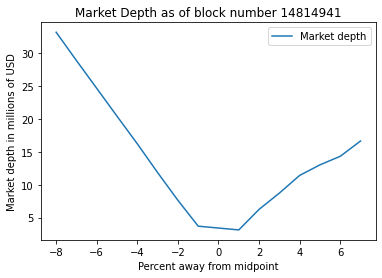

In [35]:
%%time
########### INPUT BLOCK ###############

pool_add = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
tokenIn = "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"
tokenOut = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
as_of = 14814941.0
pcts = [i / 1000 for i in range(-80, 80, 10)]

#######################################

pool = v3Pool(pool_add, initialize = False)
pcts.remove(0)
swapParams = {'tokenOut': tokenIn,
            'pcts': pcts,
            'as_of': as_of}

out, heur = pool.swapToPrice(swapParams)

## plotting
fig, ax = plt.subplots()

out_df = pd.DataFrame(out, columns = ['md', 'pct']).set_index("pct")
out_df.index = out_df.index * 100
out_df = out_df['md'] / 1e6 / 1e6
ax.plot(out_df, label = "Market depth")
ax.set_ylabel("Market depth in millions of USD")
ax.set_xlabel("Percent away from midpoint")
ax.legend()
ax.set_title('Market Depth as of block number {}'.format(as_of))

### 2. Single Transaction Simulation
* Useful when traders want to analyze specific opportunities on the blockchain, and search for optimal ways to maximize earnings
* Current Implementation:
```
    - Input: swapParams such as {'tokenIn': tokenIn,
                                 'tokenOut': tokenOut,
                                 'input': swapIn,
                                 'gasFee': True,
                                 'as_of': as_of},
             pool object

    - Output options: 
        1. output amount given input
        2. input amount required given target price impact / final price
```       
 
* Quick iterationss:
    - Support more convenient input (automatically take care of decimals etc)

In [37]:
%%time
########### INPUT BLOCK ###############

pool_add              = '0x60594a405d53811d3bc4766596efd80fd545a270'
block_number          = 13940777
transaction_index     = 0
swapParams            = {'tokenIn': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
                         'tokenOut': '0x6b175474e89094c44da98b954eedeac495271d0f',
                         'input': 1.26241e+21,
                         'gasFee': True,
                         'as_of': block_number + transaction_index / 1e4}
    
#######################################

pool = v3Pool(pool_add, initialize = False)
rez = pool.swapIn(swapParams)
output = rez[0]
heur = rez[1]
summ = {
    'total_output': output,
    'totalFee': heur[0],
    'crossed_ticks': heur[1], 
    'liquidity_in_range': heur[2], 
    'sqrt_P': heur[3], 
    'sqrtP_next': heur[4], 
    'inRangeTest': heur[5], 
    'swapInMinusFee': heur[6], 
    'zeroForOne': heur[7], 
    'gas_fee': heur[8]
}


print('tx details summary: ')
print(pd.Series(summ).to_string())

Initializing liquidity
tx details summary: 
total_output          3424668978861945120620544
totalFee                     631205000000000000
crossed_ticks                              3132
liquidity_in_range           4121650020237137.0
sqrt_P                   0.01617343166048873862
sqrtP_next               0.07744005435068702925
inRangeTest               6107465284069610496.0
swapInMinusFee         1261778794999999889408.0
zeroForOne                                False
gas_fee                   0.0230605291195440168
CPU times: user 27.2 s, sys: 19.4 s, total: 46.5 s
Wall time: 1min 11s


### 3. Trading Strategy Backtest
* Useful when traders want to backtest a specific strategy with historical data, and better understand performance (especially trade-off between expected excess return and T-cost .
* Current Implementation
    - Input: array of [timestamp: trades]
    - Output: useful summary stats on backtest results
* Quick Iterations:
    * Support arbitrary benchmarks
    * Better summary stats

Initializing liquidity
CPU times: user 1min 11s, sys: 28.4 s, total: 1min 40s
Wall time: 2min


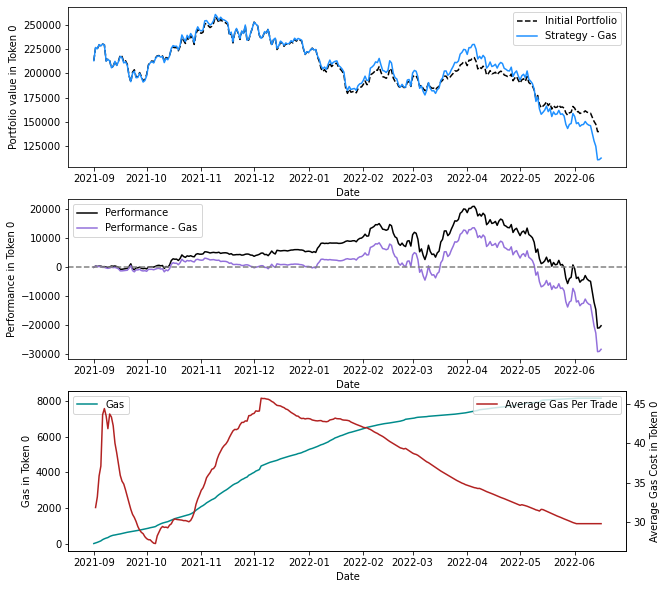

In [20]:
%%time
########### INPUT BLOCK ###############

pool_add = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
initial_port = [100000 * 1e6, 33 * 1e18]
start, end = pd.to_datetime("09-01-2021"), pd.to_datetime('06-01-2022')
## NOTE: THIS EXAMPLE USES A RANDOM PORTFOLIO GENERATED BELOW!

#######################################



pool = v3Pool(pool_add, initialize = False)
s = sim(pool)
## create trades
token0 = pool.getToken0()
token1 = pool.getToken1()

## random trading portfolio
pct = .05
times = [*pd.date_range(start=start, end=end) + pd.Timedelta("6h")]
trades = [[t, np.random.choice([token0, token1])] for t in times]
trades = [t + [initial_port[0] * pct if t[1] == token0 else initial_port[1] * pct] for t in trades]


# define trades for trades
s.defBTDate(start, end + pd.Timedelta("15d"))
s.loadPort(initial_port)

# load trades
s.loadTrades(trades)

# apply and compute performance
s.applyTrades(gas = True)
sim_df = s.createPerformance()

# plot performance
fig = s.plotMetrics()
